# Machine Learning Case Study

### Problem Statement

This case consists of a supervised learning example, similar to what we are
working with on a daily basis in Klarna . Your task is to predict the probability
of default for the datapoints where the default variable is not set. The
answer should contain the resulting predictions in a csv file with two columns,
uuid and pd (probability of default==1). Once done expose this model
with an API Endpoint on a cloud provider of your choice. Bonus points if you
use AWS. Send us the details on how to query the endpoint, attach code used
for modelling, a short (max one page) explanation of your model and how you
validated it.

We mostly use Python for modeling at Klarna but you are free to use other
languages if you prefer as long as they are easily obtainable for us.
Don’t spend too much time on the prediction results. We evaluate how you
structure and reason about the problem rather than the predictive accuracy of
your model.

### Dataset

The data is located in the attached file dataset.csv. This is a simple semicolon
separated CSV file containing a unique id, the target variable default and a
number of features with somewhat different datatypes and meanings. Missing
values are denoted as NA in the set. Here is a list of the variables and their
types:

- uuid: text
- default: categorical
- account_amount_added_12_24m: numeric
- account_days_in_dc_12_24m: numeric
- account_days_in_rem_12_24m: numeric
- account_days_in_term_12_24m: numeric
- account_incoming_debt_vs_paid_0_24m: numeric
- account_status: categorical
- account_worst_status_0_3m: categorical
- account_worst_status_12_24m: categorical
- account_worst_status_3_6m: categorical
- account_worst_status_6_12m: categorical
- age: numeric
- avg_payment_span_0_12m: numeric
- avg_payment_span_0_3m: numeric
- merchant_category: categorical
- merchant_group: categorical
- has_paid: boolean
- max_paid_inv_0_12m: numeric
- max_paid_inv_0_24m: numeric
- name_in_email: categorical
- num_active_div_by_paid_inv_0_12m: numeric
- num_active_inv: numeric
- num_arch_dc_0_12m: numeric
- num_arch_dc_12_24m: numeric
- num_arch_ok_0_12m: numeric
- num_arch_ok_12_24m: numeric
- num_arch_rem_0_12m: numeric
- num_arch_written_off_0_12m: numeric
- num_arch_written_off_12_24m: numeric
- num_unpaid_bills: numeric
- status_last_archived_0_24m: categorical
- status_2nd_last_archived_0_24m: categorical
- status_3rd_last_archived_0_24m: categorical
- status_max_archived_0_6_months: categorical
- status_max_archived_0_12_months: categorical
- status_max_archived_0_24_months: categorical
- recovery_debt: numeric
- sum_capital_paid_account_0_12m: numeric
- sum_capital_paid_account_12_24m: numeric
- sum_paid_inv_0_12m: numeric
- time_hours: numeric
- worst_status_active_inv: categorical

# Data Exploration and Preparation

## Loading the data

- This section includes loading of the data, understanding basic description of the data; followed by cleanup & imputations if required.

In [383]:
# Importing the required packages

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

%matplotlib inline

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
import category_encoders as ce


# from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier, EasyEnsembleClassifier
from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

import warnings
warnings.filterwarnings('ignore')

In [343]:
# to print all the columns
pd.set_option('display.max_columns', None)

In [344]:
# Loading the dataset and previewing the shape of the dataframe

account_data = pd.read_csv('../ML_Case_Study_local/dataset.csv', sep=';')
print("The shape of the sales data is:",account_data.shape)

The shape of the sales data is: (99976, 43)


In [345]:
# Previewing the data

account_data.head(5)

,uuid,default,account_amount_added_12_24m,account_days_in_dc_12_24m,account_days_in_rem_12_24m,account_days_in_term_12_24m,account_incoming_debt_vs_paid_0_24m,account_status,account_worst_status_0_3m,account_worst_status_12_24m,account_worst_status_3_6m,account_worst_status_6_12m,age,avg_payment_span_0_12m,avg_payment_span_0_3m,merchant_category,merchant_group,has_paid,max_paid_inv_0_12m,max_paid_inv_0_24m,name_in_email,num_active_div_by_paid_inv_0_12m,num_active_inv,num_arch_dc_0_12m,num_arch_dc_12_24m,num_arch_ok_0_12m,num_arch_ok_12_24m,num_arch_rem_0_12m,num_arch_written_off_0_12m,num_arch_written_off_12_24m,num_unpaid_bills,status_last_archived_0_24m,status_2nd_last_archived_0_24m,status_3rd_last_archived_0_24m,status_max_archived_0_6_months,status_max_archived_0_12_months,status_max_archived_0_24_months,recovery_debt,sum_capital_paid_account_0_12m,sum_capital_paid_account_12_24m,sum_paid_inv_0_12m,time_hours,worst_status_active_inv
0,63f69b2c-8b1c-4740-b78d-52ed9a4515ac,0.0,0,0.0,0.0,0.0,0.0,1.0,1.0,NaN,1.0,NaN,20,12.692308,8.333333,Dietary supplements,Health & Beauty,True,31638.0,31638.0,no_match,0.153846,2,0,0,13,14,0,0.0,0.0,2,1,1,1,1,1,1,0,0,0,178839,9.653333,1.0
1,0e961183-8c15-4470-9a5e-07a1bd207661,0.0,0,0.0,0.0,0.0,NaN,1.0,1.0,1.0,1.0,1.0,50,25.833333,25.000000,Books & Magazines,Entertainment,True,13749.0,13749.0,F+L,0.000000,0,0,0,9,19,3,0.0,0.0,0,1,1,1,1,2,2,0,0,0,49014,13.181389,NaN
2,d8edaae6-4368-44e0-941e-8328f203e64e,0.0,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,22,20.000000,18.000000,Diversified entertainment,Entertainment,True,29890.0,29890.0,L1+F,0.071429,1,0,0,11,0,3,0.0,0.0,1,1,1,1,1,2,2,0,0,0,124839,11.561944,1.0
3,0095dfb6-a886-4e2a-b056-15ef45fdb0ef,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36,4.687500,4.888889,Diversified entertainment,Entertainment,True,40040.0,40040.0,F1+L,0.031250,1,0,0,31,21,0,0.0,0.0,1,1,1,1,1,1,1,0,0,0,324676,15.751111,1.0
4,c8f8b835-5647-4506-bf15-49105d8af30b,0.0,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,25,13.000000,13.000000,Electronic equipment & Related accessories,Electronics,True,7100.0,7100.0,F+L,0.000000,0,0,0,1,0,0,0.0,0.0,0,1,0,0,1,1,1,0,0,0,7100,12.698611,NaN


## Variable Identification

In [346]:
print("Looking at individual features:\n")
# account_data.info()
account_data.dtypes

Looking at individual features:



uuid                                    object
default                                float64
account_amount_added_12_24m              int64
account_days_in_dc_12_24m              float64
account_days_in_rem_12_24m             float64
account_days_in_term_12_24m            float64
account_incoming_debt_vs_paid_0_24m    float64
account_status                         float64
account_worst_status_0_3m              float64
account_worst_status_12_24m            float64
account_worst_status_3_6m              float64
account_worst_status_6_12m             float64
age                                      int64
avg_payment_span_0_12m                 float64
avg_payment_span_0_3m                  float64
merchant_category                       object
merchant_group                          object
has_paid                                  bool
max_paid_inv_0_12m                     float64
max_paid_inv_0_24m                     float64
name_in_email                           object
num_active_di

In [347]:
print("Unique values in target are:{}".format(account_data['default'].unique()))
# print(Counter(account_data['default']))
# 0.0: 88688, 1.0: 1288
print("Count of unique values in target are:{}".format(account_data['default'].isnull().sum()))

Unique values in target are:[ 0.  1. nan]
Count of unique values in target are:10000


In [348]:
# Checking for unique values

account_data.nunique()

uuid                                   99976
default                                    2
account_amount_added_12_24m            23721
account_days_in_dc_12_24m                127
account_days_in_rem_12_24m               282
account_days_in_term_12_24m               64
account_incoming_debt_vs_paid_0_24m    23674
account_status                             4
account_worst_status_0_3m                  4
account_worst_status_12_24m                4
account_worst_status_3_6m                  4
account_worst_status_6_12m                 4
age                                       79
avg_payment_span_0_12m                  7939
avg_payment_span_0_3m                   2256
merchant_category                         57
merchant_group                            12
has_paid                                   2
max_paid_inv_0_12m                     12497
max_paid_inv_0_24m                     12932
name_in_email                              8
num_active_div_by_paid_inv_0_12m         861
num_active

In [349]:
# looking at nan values accross dataset

account_data.isnull().sum()

uuid                                       0
default                                10000
account_amount_added_12_24m                0
account_days_in_dc_12_24m              11836
account_days_in_rem_12_24m             11836
account_days_in_term_12_24m            11836
account_incoming_debt_vs_paid_0_24m    59315
account_status                         54373
account_worst_status_0_3m              54373
account_worst_status_12_24m            66761
account_worst_status_3_6m              57702
account_worst_status_6_12m             60350
age                                        0
avg_payment_span_0_12m                 23836
avg_payment_span_0_3m                  49305
merchant_category                          0
merchant_group                             0
has_paid                                   0
max_paid_inv_0_12m                         0
max_paid_inv_0_24m                         0
name_in_email                              0
num_active_div_by_paid_inv_0_12m       22939
num_active

In [350]:
# finding frequencies in categorical variables
categorical = [var for var in account_data.columns if account_data[var].dtype=='O']

print("Number of categorical variables:{}".format(len(categorical)))
print("The categorical variables are:",categorical)

for i in categorical:
    print(account_data[i].value_counts)

Number of categorical variables:4
The categorical variables are: ['uuid', 'merchant_category', 'merchant_group', 'name_in_email']
<bound method IndexOpsMixin.value_counts of 0        63f69b2c-8b1c-4740-b78d-52ed9a4515ac
1        0e961183-8c15-4470-9a5e-07a1bd207661
2        d8edaae6-4368-44e0-941e-8328f203e64e
3        0095dfb6-a886-4e2a-b056-15ef45fdb0ef
4        c8f8b835-5647-4506-bf15-49105d8af30b
                         ...                 
99971    5c03bc63-ea65-4ffd-aa7b-95ea9a46db34
99972    f8db22f4-9819-420c-abbc-9ddf1843176e
99973    b22e21ea-b1b2-4df3-b236-0ff6d5fdc0d8
99974    bafcab15-9898-479c-b729-c9dda7edb78f
99975    ac88f18c-96a6-49bc-9e9d-a780225914af
Name: uuid, Length: 99976, dtype: object>
<bound method IndexOpsMixin.value_counts of 0                               Dietary supplements
1                                 Books & Magazines
2                         Diversified entertainment
3                         Diversified entertainment
4        Electronic equipm

In [351]:
# checking for duplicate records

print("Number of duplicate records are:{}".format(account_data.duplicated().sum()))

Number of duplicate records are:0


In [352]:
account_data.describe().T

,count,mean,std,min,25%,50%,75%,max
default,89976.0,0.014315,0.118786,0.000000,0.000000,0.000000,0.000000,1.000000e+00
account_amount_added_12_24m,99976.0,12255.149516,35481.483737,0.000000,0.000000,0.000000,4937.250000,1.128775e+06
account_days_in_dc_12_24m,88140.0,0.223043,5.808117,0.000000,0.000000,0.000000,0.000000,3.650000e+02
account_days_in_rem_12_24m,88140.0,5.044622,22.863971,0.000000,0.000000,0.000000,0.000000,3.650000e+02
account_days_in_term_12_24m,88140.0,0.286896,2.929910,0.000000,0.000000,0.000000,0.000000,9.700000e+01
account_incoming_debt_vs_paid_0_24m,40661.0,1.331292,26.482299,0.000000,0.000000,0.152082,0.662952,3.914000e+03
account_status,45603.0,1.042168,0.202713,1.000000,1.000000,1.000000,1.000000,4.000000e+00
account_worst_status_0_3m,45603.0,1.172905,0.420142,1.000000,1.000000,1.000000,1.000000,4.000000e+00
account_worst_status_12_24m,33215.0,1.337348,0.575043,1.000000,1.000000,1.000000,2.000000,4.000000e+00
account_worst_status_3_6m,42274.0,1.185291,0.443309,1.000000,1.000000,1.000000,1.000000,4.000000e+00


In [353]:
account_data.isnull().sum()

uuid                                       0
default                                10000
account_amount_added_12_24m                0
account_days_in_dc_12_24m              11836
account_days_in_rem_12_24m             11836
account_days_in_term_12_24m            11836
account_incoming_debt_vs_paid_0_24m    59315
account_status                         54373
account_worst_status_0_3m              54373
account_worst_status_12_24m            66761
account_worst_status_3_6m              57702
account_worst_status_6_12m             60350
age                                        0
avg_payment_span_0_12m                 23836
avg_payment_span_0_3m                  49305
merchant_category                          0
merchant_group                             0
has_paid                                   0
max_paid_inv_0_12m                         0
max_paid_inv_0_24m                         0
name_in_email                              0
num_active_div_by_paid_inv_0_12m       22939
num_active

In [354]:
# Dropping redundant and unnecessary columns

col_to_drop = ['uuid','name_in_email', 'status_max_archived_0_6_months','status_max_archived_0_12_months','avg_payment_span_0_3m', 'max_paid_inv_0_12m']
account_data.drop(col_to_drop, axis=1, inplace=True)

# Converting boolean column to integer

account_data['has_paid'] = account_data['has_paid'].astype(int)

#### Initial Observations:

- There are a total of 99976 records in the dataset with 10000 records whose default value is unknown which becomes our test set.
- There are a total of 42 features and 1 target variable in the dataset, a dimensionality reduction may be required to reduce the number of features.
- We shall retain the uuid column for now since this is needed to be displayed in the result.
- There are no duplicate records.
- There are no negative values as shown from the min values.
- The columns have different ranges and magnitudes which suggests that scaling could be required if distance based algorithms are used.
- Few of the columns have very high count of NaNs compared to others

# Outlier treatment

## Missing value treatment

In [355]:
# Checking for percentage of missing value in each column

# round(account_data.isnull().sum()/len(account_data)*100,2)

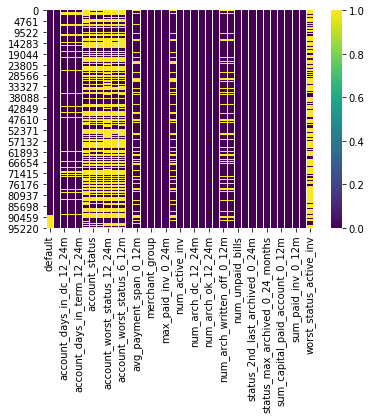

In [356]:
# Visualizing missing values across data

sns.heatmap(account_data.isnull(), cmap='viridis');

In [357]:
# Finding number of categories in numeric columns

num_nul_cols = ['avg_payment_span_0_12m', 'account_incoming_debt_vs_paid_0_24m',
               'account_days_in_dc_12_24m', 'account_days_in_rem_12_24m', 'account_days_in_term_12_24m', 'num_active_div_by_paid_inv_0_12m']

# num_nul_cols = X_train.select_dtypes(include=['int64','float64']).columns
# num_cols_x_train = X_train._get_numeric_data()

for ColName in num_nul_cols:
    print("{} = {}".format(ColName,account_data[ColName].nunique()))
    print(account_data[ColName].value_counts(dropna=False))

avg_payment_span_0_12m = 7939
NaN          23836
14.000000     2144
13.000000     1833
15.000000     1281
12.000000     1227
             ...  
5.913043         1
9.725191         1
10.611111        1
6.822222         1
14.792453        1
Name: avg_payment_span_0_12m, Length: 7940, dtype: int64
account_incoming_debt_vs_paid_0_24m = 23674
NaN          59315
0.000000     13072
8.034426        57
0.004301        18
0.000022        17
             ...  
0.308098         1
0.586757         1
11.695556        1
0.268112         1
0.900313         1
Name: account_incoming_debt_vs_paid_0_24m, Length: 23675, dtype: int64
account_days_in_dc_12_24m = 127
0.0      87879
NaN      11836
9.0         11
28.0        10
67.0         9
         ...  
113.0        1
106.0        1
362.0        1
143.0        1
159.0        1
Name: account_days_in_dc_12_24m, Length: 128, dtype: int64
account_days_in_rem_12_24m = 282
0.0      78522
NaN      11836
1.0        529
2.0        315
21.0       258
         ...  
3

In [358]:
# Printing percentage of missing values in numerical varibles
account_data[num_nul_cols].isnull().sum()*100/len(account_data)

avg_payment_span_0_12m                 23.841722
account_incoming_debt_vs_paid_0_24m    59.329239
account_days_in_dc_12_24m              11.838841
account_days_in_rem_12_24m             11.838841
account_days_in_term_12_24m            11.838841
num_active_div_by_paid_inv_0_12m       22.944507
dtype: float64

- From the numeric columns, we see that the percentage of missing values in these are below 25% for all expect for account_incoming_debt_vs_paid_0_24m. Hence, we chose to perform mean imputation for all these and chose to not drop the accoutn_incoming_debt_vs_paid_0_24m feature as it seems to be a useful feature for our prediction.

In [359]:
# Using mean imputation to impute float variables

account_data[num_nul_cols] = account_data[num_nul_cols].fillna(account_data[num_nul_cols].mean())

In [360]:
# Finding number of categories in category columns

print("Number of Categories in: ")

cat_nul_cols = ['account_status', 'account_worst_status_0_3m', 'account_worst_status_12_24m',
            'account_worst_status_3_6m', 'account_worst_status_6_12m', 'num_arch_written_off_0_12m',
            'num_arch_written_off_12_24m', 'worst_status_active_inv']

for ColName in cat_nul_cols:
    print("{} = {}".format(ColName,account_data[ColName].nunique()))
    print(account_data[ColName].value_counts(dropna=False))

Number of Categories in: 
account_status = 4
NaN    54373
1.0    43693
2.0     1900
3.0        7
4.0        3
Name: account_status, dtype: int64
account_worst_status_0_3m = 4
NaN    54373
1.0    38375
2.0     6678
3.0      443
4.0      107
Name: account_worst_status_0_3m, dtype: int64
account_worst_status_12_24m = 4
NaN    66761
1.0    23527
2.0     8433
3.0      993
4.0      262
Name: account_worst_status_12_24m, dtype: int64
account_worst_status_3_6m = 4
NaN    57702
1.0    35254
2.0     6357
3.0      513
4.0      150
Name: account_worst_status_3_6m, dtype: int64
account_worst_status_6_12m = 4
NaN    60350
1.0    30703
2.0     8025
3.0      688
4.0      210
Name: account_worst_status_6_12m, dtype: int64
num_arch_written_off_0_12m = 2
0.0    81888
NaN    18078
1.0       10
Name: num_arch_written_off_0_12m, dtype: int64
num_arch_written_off_12_24m = 3
0.0    81887
NaN    18078
1.0        9
2.0        2
Name: num_arch_written_off_12_24m, dtype: int64
worst_status_active_inv = 3
NaN    6

In [361]:
# Printing percentage of missing values in categorical varibles
account_data[cat_nul_cols].isnull().sum()*100/len(account_data)

account_status                 54.386053
account_worst_status_0_3m      54.386053
account_worst_status_12_24m    66.777026
account_worst_status_3_6m      57.715852
account_worst_status_6_12m     60.364487
num_arch_written_off_0_12m     18.082340
num_arch_written_off_12_24m    18.082340
worst_status_active_inv        69.531688
dtype: float64

In [362]:
# Using Frequency imputation to impute the categorical variables with the most frequent category

def fillna(col):
    col.fillna(col.value_counts().index[0], inplace=True)
    return col

account_data[['account_status','num_arch_written_off_0_12m','num_arch_written_off_12_24m']]=account_data[['account_status','num_arch_written_off_0_12m','num_arch_written_off_12_24m']].apply(lambda col:fillna(col))
account_data.drop(['account_worst_status_0_3m','account_worst_status_12_24m','account_worst_status_3_6m',
                         'account_worst_status_6_12m','worst_status_active_inv'], inplace=True, axis=1)

- For the categorical variables with missing values greater than 50 percentage we chose to drop except for account_status

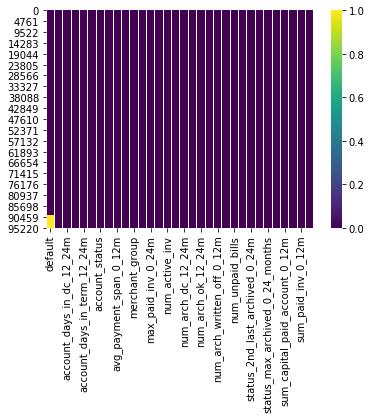

In [363]:
# Visualizing missing values across data

sns.heatmap(account_data.isnull(), cmap='viridis');

## Multivariate Analysis

In [364]:
# num_cols = [var for var in account_data.columns if account_data[var].dtype=='int64' or account_data[var].dtype=='float64']
# # num_cols = account_data._get_numeric_data().columns

# # sns.pairplot(account_data[num_cols])
# # account_data[num_cols].hist(figsize=(30,30));

## Multicollinearity check

In [365]:
print(account_data.corr(method="kendall")["default"])

default                                1.000000
account_amount_added_12_24m            0.020975
account_days_in_dc_12_24m             -0.004328
account_days_in_rem_12_24m             0.049873
account_days_in_term_12_24m            0.015339
account_incoming_debt_vs_paid_0_24m    0.000704
account_status                         0.098890
age                                   -0.038425
avg_payment_span_0_12m                 0.067022
has_paid                              -0.032081
max_paid_inv_0_24m                    -0.050879
num_active_div_by_paid_inv_0_12m       0.061315
num_active_inv                         0.025360
num_arch_dc_0_12m                      0.099954
num_arch_dc_12_24m                     0.092779
num_arch_ok_0_12m                     -0.088533
num_arch_ok_12_24m                    -0.078749
num_arch_rem_0_12m                    -0.005525
num_arch_written_off_0_12m             0.018710
num_arch_written_off_12_24m           -0.001205
num_unpaid_bills                       0

In [366]:
plt.figure(figsize=(20,8))
# sns.heatmap(account_data.corr(),cmap='RdBu',annot=True);

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

In [367]:
# # account_data.drop(labels=['status_3rd_last_archived_0_24m'], inplace=True, axis=1)
# # account_data.drop(labels=['status_max_archived_0_24_months'], inplace=True, axis=1)
# # account_data.drop(labels=['sum_capital_paid_account_12_24m'], inplace=True, axis=1)
# account_data.drop(labels=['num_arch_ok_12_24m'], inplace=True, axis=1)

In [368]:
# plt.figure(figsize=(20,8))
# sns.heatmap(account_data.corr(),cmap='RdBu',annot=True);

In [369]:
# Splitting the data frame
Train = account_data[account_data['default'].isna()==False]
Test = account_data[account_data['default'].isna()]

print(Train.shape)
print(Test.shape)

X_train, X_test, y_train, y_test = train_test_split(Train.iloc[:,1:37],Train.iloc[:,0],train_size=0.7,random_state=42)

(89976, 32)
(10000, 32)


In [370]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(62983, 31)
(26993, 31)
(62983,)
(26993,)


# Model Building

## Encoding

In [371]:
# Target encoding Function

def target_encoder(X_train, X_test, y_train, high_categ):

    for col in high_categ:
        X_train.loc[:,col] = X_train[col].astype('category')
        X_test.loc[:,col] = X_test[col].astype('category')
    
    # Target encoding features with many levels
    te = ce.TargetEncoder()
    te.fit(X_train[high_categ],y_train)
    X_train = X_train.join(te.transform(X_train[high_categ]).add_suffix('_target'))
    X_test = X_test.join(te.transform(X_test[high_categ]).add_suffix('_target'))

    # Dropping redundant columns
    X_train.drop(high_categ, inplace= True, axis=1)
    X_test.drop(high_categ, inplace= True, axis=1)
    
    return X_train,X_test

In [372]:
# Target encoding categorical columns since they have many levels and one-hot encoding will increase the dimensions a lot, 
# furthermore, since we have large data using target encoder will not create overfitting problem.

high_categ = ['merchant_category','merchant_group']

X_train, X_test = target_encoder(X_train,X_test,y_train,high_categ)

## Checking Class Imbalance

In [373]:
print("Percentage of 0 class in data:", len(Train[Train['default']==0])*100/len(Train))

Percentage of 0 class in data: 98.56850715746421


In [374]:
print("Percentage of 1 class in data:", len(Train[Train['default']==1])*100/len(Train))

Percentage of 1 class in data: 1.4314928425357873


- There is clearly class imbalance problem and a regular random forest will overfit

### SMOTE Oversampling

In [375]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(62983, 31)
(62983,)
(26993, 31)
(26993,)


In [376]:
#SMOTE to create synthetic samples to balance the target classes

sm = SMOTE(sampling_strategy=0.1,random_state=42)

In [377]:
print(Counter(y_train))

Counter({0.0: 62080, 1.0: 903})


In [378]:
X_train, y_train = sm.fit_resample(X_train,y_train)
# X_test, y_test= sm.fit_resample(X_test,y_test)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(68288, 31)
(68288,)
(26993, 31)
(26993,)


In [379]:
print(Counter(y_train))

Counter({0.0: 62080, 1.0: 6208})


In [380]:
print(Counter(y_test))

Counter({0.0: 26608, 1.0: 385})


## Pipeline code

In [384]:
from sklearn.model_selection import cross_val_score


## Random forest implementation

In [381]:
#Training models and getting log loss value for each

for name, model in models:
    if name=='LR':
        
        norm=MinMaxScaler().fit(X_train)
        X_train_norm=norm.transform(X_train)
        X_test_norm=norm.transform(X_test)
        model.fit(X_train_norm, y_train)
        
#         print("FOR TRAIN:\n")
#         y_pred_train = model.predict(X_train_norm)
# #         logloss = log_loss(y_test, y_pred)
# #         print('Log Loss Score for {}: %.3f'.format(name) % (logloss))
#         print("Model: {}".format(name))
# #         print(metrics.classification_report(y_test,y_pred))
#         print("Confusion matrix:\n", metrics.confusion_matrix(y_train,y_pred_train,labels=(1,0)))
#         print("Classification report:\n",metrics.classification_report(y_train,y_pred_train,labels=(1,0)))
#         print("Accuracy score:", metrics.accuracy_score(y_train,y_pred_train))
#         print("Recall score:", metrics.recall_score(y_train,y_pred_train))
#         print("F1 score:", metrics.f1_score(y_train,y_pred_train))
#         print("ROC AUC score:", metrics.roc_auc_score(y_train,y_pred_train))
        
        print("FOR TEST:\n")
        y_pred = model.predict(X_test_norm)
#         logloss = log_loss(y_test, y_pred)
#         print('Log Loss Score for {}: %.3f'.format(name) % (logloss))
        print("Model: {}".format(name))
#         print(metrics.classification_report(y_test,y_pred))
        print("Confusion matrix:\n", metrics.confusion_matrix(y_test,y_pred,labels=(1,0)))
        print("Classification report:\n",metrics.classification_report(y_test,y_pred,labels=(1,0)))
        print("Accuracy score:", metrics.accuracy_score(y_test,y_pred))
        print("Recall score:", metrics.recall_score(y_test,y_pred))
        print("F1 score:", metrics.f1_score(y_test,y_pred))
        print("ROC AUC score:", metrics.roc_auc_score(y_test,y_pred))
    else:
        model.fit(X_train, y_train)
        
#         print("FOR TRAIN:\n")
#         y_pred_train = model.predict(X_train_norm)
# #         logloss = log_loss(y_test, y_pred)
# #         print('Log Loss Score for {}: %.3f'.format(name) % (logloss))
#         print("Model: {}".format(name))
# #         print(metrics.classification_report(y_test,y_pred))
#         print("Confusion matrix:\n", metrics.confusion_matrix(y_train,y_pred_train,labels=(1,0)))
#         print("Classification report:\n",metrics.classification_report(y_train,y_pred_train,labels=(1,0)))
#         print("Accuracy score:", metrics.accuracy_score(y_train,y_pred_train))
#         print("Recall score:", metrics.recall_score(y_train,y_pred_train))
#         print("F1 score:", metrics.f1_score(y_train,y_pred_train))
#         print("ROC AUC score:", metrics.roc_auc_score(y_train,y_pred_train))
        
        print("FOR TEST:\n")
        
        y_pred = model.predict(X_test)
#         logloss = log_loss(y_test, y_pred)
#         print('Log Loss Score for {}: %.3f'.format(name) % (logloss))
        print("Model: {}".format(name))
#         print(metrics.classification_report(y_test,y_pred))
        print("Confusion matrix:\n", metrics.confusion_matrix(y_test,y_pred,labels=(1,0)))
        print("Classification report:\n",metrics.classification_report(y_test,y_pred,labels=(1,0)))
        print("Accuracy score:", metrics.accuracy_score(y_test,y_pred))
        print("Recall score:", metrics.recall_score(y_test,y_pred))
        print("F1 score:", metrics.f1_score(y_test,y_pred))
        print("ROC AUC score:", metrics.roc_auc_score(y_test,y_pred))

FOR TEST:

Model: LR
Confusion matrix:
 [[   64   321]
 [  374 26234]]
Classification report:
               precision    recall  f1-score   support

           1       0.15      0.17      0.16       385
           0       0.99      0.99      0.99     26608

    accuracy                           0.97     26993
   macro avg       0.57      0.58      0.57     26993
weighted avg       0.98      0.97      0.98     26993

Accuracy score: 0.9742525840032601
Recall score: 0.16623376623376623
F1 score: 0.1555285540704739
ROC AUC score: 0.5760889216015493
FOR TEST:

Model: RF
Confusion matrix:
 [[   37   348]
 [   77 26531]]
Classification report:
               precision    recall  f1-score   support

           1       0.32      0.10      0.15       385
           0       0.99      1.00      0.99     26608

    accuracy                           0.98     26993
   macro avg       0.66      0.55      0.57     26993
weighted avg       0.98      0.98      0.98     26993

Accuracy score: 0.984255

# Notes: Accuracy is wrong predictor to check when we have class imbalance problem - use smote oversampling then apply logistic regression and RFC. Use XGB which performs better for imbalance data and is fast too